# Algorithmic Fairness, Accountability, and Ethics, Spring 2024

## Mandatory Assignment 1

Please use the following code to prepare the dataset.
 

In [1]:
# imports
from sklearn.ensemble import RandomForestClassifier
from folktables.acs import adult_filter
from folktables import ACSDataSource
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from mlxtend.evaluate import create_counterfactual

In [2]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 'SEX']

target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: float = 35000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()]
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    ### Adult Filter (ENDS)
    ### Groups of interest
    sex = df["SEX"].values
    ### Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = {
        "HINS1": 'HINS1_2.0',
        "HINS2": 'HINS2_2.0',
        "HINS4": 'HINS4_2.0',
        "CIT": 'CIT_1.0',
        "COW" : 'COW_1.0',
        "SCHL" : 'SCHL_16.0',
        "MAR": 'MAR_5.0',
        "SEX": 'SEX_1.0',
        "RAC1P" :'RAC1P_1.0',
        "ENG" : 'ENG_1.0',
        }
    drop_cols = []
    for i in cols: 
        if cols[i] == '':
            drop_first = f'{i}_{df_processed[i].value_counts().idxmax()}'
            cols[i] = drop_first
        else:
            drop_first = cols[i]
        drop_cols.append(drop_first)
        df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=True, columns=[i]) ; df_processed.drop(columns=drop_first, inplace=True)
    return df_processed, df, target, sex, cols

data, data_original, target, group, cols = data_processing(acs_data, feature_names, target_name)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data, target, group, test_size=0.2, random_state=0)

### TASK 2 - Logistic regression

Task 2.1

In [3]:
#applying scaling to the relevant columns
scaler = MinMaxScaler()
X_train[["AGEP"]] = scaler.fit_transform(X_train[["AGEP"]])
X_test[["AGEP"]] = scaler.fit_transform(X_test[["AGEP"]])

In [4]:
#Training the logistic regression model
model = LogisticRegression(max_iter=5000, penalty= "l2", C= 0.8497534359086438, tol=1e-4, solver = "saga")
model.fit(X_train, y_train)

LogisticRegression(C=0.8497534359086438, max_iter=5000, solver='saga')

In [5]:
#calculating the feature importance for the logistic regression model
coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': np.abs(coefficients)})

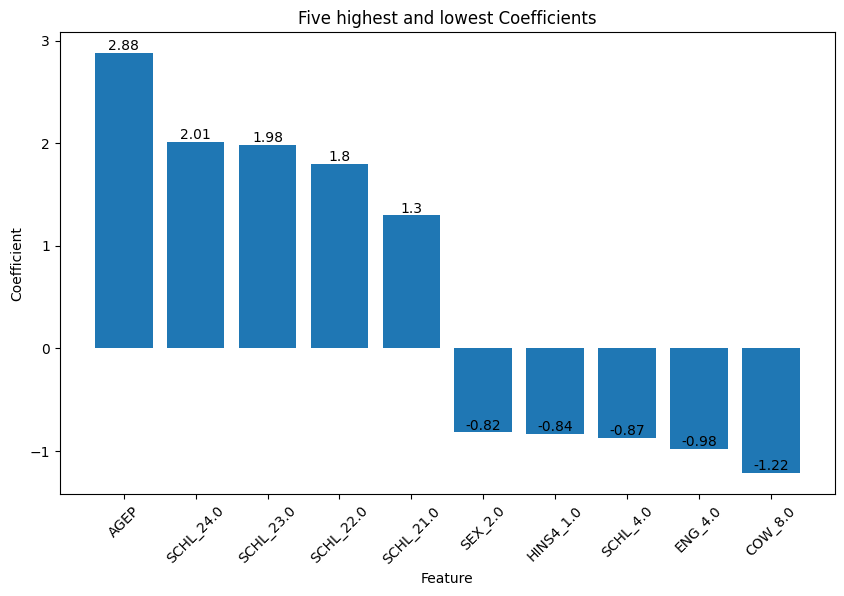

In [93]:
# Get the top 5 and bottom 5 coefficients
top_5_coeffs = coefficients_df.head(5)
bottom_5_coeffs = coefficients_df.tail(5)

# Concatenate the top and bottom coefficients
coefficients = pd.concat([top_5_coeffs, bottom_5_coeffs])

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(coefficients['Feature'], coefficients['Coefficient'])
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Five highest and lowest Coefficients')

# Add values to the bars
for i, coeff in enumerate(coefficients['Coefficient']):
    plt.text(i, coeff, str(round(coeff, 2)), ha='center', va='bottom')

plt.xticks(rotation=45)
plt.show()



In [7]:
#accuracy of the model
model.score(X_test, y_test)

0.7696317685840595

### Counterfactual

Task 2.2

In [125]:
# Create a dataframe with the predicted probabilities
probs = model.predict_proba(X_test)
probs_df = pd.DataFrame({'Index': X_test.index, 'Probability 0': probs[:,0], "probability 1": probs[:,1], "predicted": model.predict(X_test), 'Actual': y_test, "Sex" : X_test["SEX_2.0"]})

In [122]:
# Calculate the absolute difference between probability 0 and probability 1
probs_df['diff'] = abs(probs_df['Probability 0'] - probs_df['probability 1'])
# Sort the dataframe by the absolute difference
probs_df_sorted = probs_df.sort_values('diff')
# Select the top 5 rows with the closest probabilities
selected_people = probs_df_sorted.head(3)
# Print the selected people
print(selected_people)


         Index  Probability 0  probability 1  predicted  Actual    Sex  \
191000  191000       0.500005       0.499995      False    True   True   
24663    24663       0.499978       0.500022       True    True   True   
283476  283476       0.499971       0.500029       True   False  False   

            diff  
191000  0.000011  
24663   0.000044  
283476  0.000058  


In [123]:
#Choose one person for the counterfactual from the list of people with the closest probabilities 
person = X_test[24663:24664]
#Change original value of sex to the opposite
person.loc[person["SEX_2.0"]] = False
#make the new prediction
new_pred = model.predict(person)
# printing the counterfactual
print("New prediction:", new_pred[0], "- Original prediction:", probs_df['predicted'][24663], "- New probability", model.predict_proba(person))


New prediction: False - Original prediction: True - New probability [[0.76393244 0.23606756]]
